<center>
<img src="https://raw.githubusercontent.com/dvgodoy/PyTorch101_ODSC_Europe2020/master/images/linear_dogs.jpg" width="800">

# Основы глубинного обучения: домашнее задание 4
</center>

**ФИО:** Лаптева Анна

**Забавный факт о себе:** Люблю одуванчики

## Общая информация

__Дата выдачи:__ 09.12.2023

__Дедлайн:__ 23:59MSK 18.12.2023

В случае этой домашки мягкий дедлан совпадает с жёстким.

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 5.2 балла (3 основных балла и ещё 2.2 бонусных).

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

In [2]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Описание данных

Данные можно [скачать с гугл-диска.](https://drive.google.com/drive/folders/11oCcLplWtp_qm-WuEbfCFP_Mz5K_z3ps?usp=sharing) Если вы делаете задание в колабе, то строчки ниже сами скачают вам данные.



In [3]:
import gdown

url = "https://drive.google.com/drive/folders/1GAHx4R0DAe9R_IJuJGJE7feYpPc4Rhs4?usp=sharing"
gdown.download_folder(url, quiet=True, use_cookies=False)

['/content/news_data/ria_news.tsv',
 '/content/news_data/vk_comments.tsv',
 '/content/news_data/vk_news.tsv']

В таблице `ria_news.tsv`  лежат данные о новостях, вышедших на сайте РИА-НОВОСТИ с 15 марта 2018 года по 31 декабря 2018 года.

- `href` - уникальный идентификатор новости (ссылка на неё)
- `date` - дата публикации новости
- `time` - время публикации новости
- `title` - заголовок новости
- `snippet` - краткое описание новости
- `text` - текст новости
- `category` - категория новости
- `keywords` - ключевые слова (подкатегории новости)
- `shows` - счётчик с числом просмотров новости на сайте (на момент парсинга)

In [3]:
df_ria = pd.read_csv('news_data/ria_news.tsv', sep='\t')
df_ria = df_ria[~df_ria.tags.isnull()]
print(df_ria.shape)
df_ria.head()

(201708, 9)


,href,date,time,title,snippet,text,category,tags,shows
0,/20181231/1548961410.html,2018-12-31,"31 декабря 2018, 23:52",Нетаньяху не собирается в отставку в случае пр...,Премьер-министр Израиля Биньямин Нетаньяху не ...,"МОСКВА, 31 дек - РИА Новости. Премьер-министр ...",В мире,"Биньямин Нетаньяху, Израиль, В мире",728.0
1,/20181231/1548961364.html,2018-12-31,"31 декабря 2018, 23:19",Макрон в новогоднем обращении затронул тему ре...,"Результат реформ не может быть мгновенным, зая...","ПАРИЖ, 31 дек – РИА Новости. Результат реформ ...",В мире,"Эммануэль Макрон, Франция, В мире",3086.0
2,/20181231/1548961337.html,2018-12-31,"31 декабря 2018, 23:12",Аарон Рэмзи проведет переговоры с пятью топ-кл...,"Полузащитник лондонского ""Арсенала"" Аарон Рэмз...","МОСКВА, 31 дек - РИА Новости. Полузащитник лон...",NaN,ФК Арсенал (Лондон),183.0
3,/20181231/1548961304.html,2018-12-31,"31 декабря 2018, 23:09",Гол Азмуна принес сборной Ирана победу над кат...,Футболисты сборной Ирана одержали победу над к...,"МОСКВА, 31 дек - РИА Новости. Футболисты сборн...",NaN,"Сердар Азмун, Сборная Ирана по футболу",78.0
4,/20181231/1548961265.html,2018-12-31,"31 декабря 2018, 23:07",Пятая ракетка мира дель Потро пропустит Открыт...,Аргентинский теннисист Хуан Мартин дель Потро ...,"МОСКВА, 31 дек - РИА Новости. Аргентинский тен...",NaN,Теннис,79.0


Многие новостные агенства поддерживают странички в социальных сетях. Они постят туда самые сочные сюжеты. В таблице `vk_news.tsv` лежат данные о новостях, которые РИА запостили ВКонтакте в период времени с  `2017-09-29 01:28:55` по `2019-02-01 23:13:17`.

- `id` - уникальный идентификатор поста
- `href` - ссылка на сайт (если она была указана в посте)
- `datetime` - дата и время публикации новости
- `title` - заголовок новости
- `text` - текст новости в социальной сети
- `likes` - число лайков под постом
- `comments` - число комментариев под постом

In [4]:
df_vk = pd.read_csv('news_data/vk_news.tsv', sep='\t')
df_vk['snippet'] = df_vk['text']
df_vk.drop('text', axis=1, inplace=True)
print(df_vk.shape)
df_vk.head()

(19928, 7)


,id,href,datetime,title,likes,comments,snippet
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN


В таблице `vk_comments.tsv` лежат комментарии к новостям.

- `id` - уникальный идентификатор комментария
- `post_id` - идентификатор новости, под которой был оставлен комментарий
- `datetime` - дата и время, когда был оставлен комментарий
- `text` - текст комментария
- `likes` - число лайков под комментарием

In [5]:
df_comments = pd.read_csv('news_data/vk_comments.tsv', sep='\t')
df_comments = df_comments[~df_comments.text.isnull()]
print(df_comments.shape)
df_comments.head()

<ipython-input-5-9f937a17e540>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_comments = pd.read_csv('news_data/vk_comments.tsv', sep='\t')


(2612629, 5)


,id,post_id,datetime,text,likes
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0


# А что надо сделать то?

В тетрадке вам предстоит сделать следующие шаги:

1. Вы обучите нейросеть предсказывать категорию новости
2. Вы построите предсказания для тех новостей, где мы ничего не знаем о категории
3. Вы используете уже обученный для сентимент-анализа классификатор из библиотеки `hugging face` чтобы предсказать эмоциональную окраску каждого комментария
4. Вы проведёте аналитику по новостям, а именно построите топы из самых позитивных и негативных категорий и новостей

Для первого шага вам будет дан бэйзлайн. Если вы его прогоните, у вас получится базовая модель, которая даст некоторое качество решения задачи. Вам надо будет выяснить, насколько это качество оказалось хорошим, а затем внести в код некоторые улучшения.



## Часть 1: категоризация новостей (1.2 + 2 бонусных балла)

Каждой новости в соотвествие поставлены ключевые слова. Будем считать, что эти ключевые слова — тематики новости. Нужно научиться предсказывать тематики по тексту новости. Готовые тематики у нас есть только по новостям с сайта. Они за 2018 год. По новостям из ВКонтакте у нас тематик нет. Мы собираемся их предсказать.

Новости, опубликованные ВКонтакте, отличаются от новостей с сайта тем, что у них есть только титул и короткое описание. Странно будет обучать нейросеть на длинных текстах, а потом использовать её на коротких описаниях. Мы не будем так делать. Мы попробуем обучить базовый вариант нейронной сети только на заголовках новостей. Все, кто захочет получить бонусные баллы, смогут попробовать добавить в нейросеть сниппеты (так назыают короткие описания новостей).

## 1.1 Подготовка таргета

Поработаем с таргетом. Мы будем предсказывать переменную `tags`. Давайте выясним скоько уникальных тегов существует.

In [6]:
from collections import Counter

# удалим все лишние пробелы и сделаем lowercase
df_ria['tags'] = (
    df_ria.tags.
    apply(lambda w: ','.join([item.strip() for item in  w.lower().split(',')]))
)

tags = ','.join(list(df_ria.tags.values))
tags_cnt = Counter(tags.split(','))

print(len(tags_cnt))
tags_cnt.most_common()[-20:]

13344


[('блог анны завершинской об автоспорте - блоги', 1),
 ('министерство транспорта рб', 1),
 ('министерство здравоохранения грузии', 1),
 ('палех', 1),
 ('юрий посохов (хореограф)', 1),
 ('мария александрова', 1),
 ('том бенсон', 1),
 ('абдул каюм кочай', 1),
 ('нуман куртулмуш', 1),
 ('mipim', 1),
 ('владимир попов', 1),
 ('брюно женезио', 1),
 ('роберт фицо', 1),
 ('сергей пашинский', 1),
 ('валерия гонтарева', 1),
 ('нововоронеж', 1),
 ('императорское православное палестинское общество', 1),
 ('event_poslanie_prezidenta_rf_federalnomu_sobraniju', 1),
 ('фхтр', 1),
 ('игорь честин', 1)]

Всего в выборке есть порядка 13 000 тэгов. Многие встречаются всего по разу. Давайте оставим в выборке только те тэги, которые встречаются более 30 раз.

In [7]:
target_tags = {tag for tag,cnt in tags_cnt.most_common() if cnt > 30}
len(target_tags)

1583

Закодируем теги для OHE.

In [8]:
tag2idx = dict(zip(target_tags, range(len(target_tags))))
idx2tag = {jtem: item for item,jtem in tag2idx.items()}

Почистим таргет от лишних тэгов.

In [9]:
df_ria['target_tags'] = (
    df_ria.tags.
    apply(lambda w: [tag2idx.get(item) for item in  w.split(',') if item in target_tags])
)

df_ria = df_ria[df_ria.target_tags.apply(len) > 0]
df_ria.shape

(201437, 10)

In [10]:
df_ria.target_tags.values[:3]

array([list([1316, 1016, 1196]), list([801, 835, 1196]), list([692])],
      dtype=object)

## 1.2 Подготовка текстов

Теперь займёмся предобработкой текстов. Приведём все слова к маленькому регистру и выбросим мусорные символы. В качестве токенов будем рассматривать отдельные слова.

Напомню, что мы пока что решили работать только с названиями статей. Поэтому вся предобработка применяется исключительно к ним. **Спойлер:** предобработку для сниппетов вы сделаете сами в первом же задании.

In [11]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
import re
from nltk.tokenize import word_tokenize

def normalise_text(text):
    text = text.lower()

    # сурово регулярками выкидываем мусорные символы
    text = re.sub('[^а-яa-z0-9 ]', '', text)
    return text.strip()

df_ria['title_clean'] = df_ria.title.apply(normalise_text)

word_cnt = Counter(word_tokenize(' '.join(df_ria.title_clean.values)))
len(word_cnt)

112178

In [13]:
word_cnt.most_common()[:10]

[('в', 127323),
 ('на', 44386),
 ('с', 26150),
 ('и', 21771),
 ('о', 19948),
 ('по', 17014),
 ('россии', 13494),
 ('не', 13483),
 ('сша', 9942),
 ('за', 9881)]

Давайте почистим словарь от стоп-слов и подготовим его к использованию внутри датасета. Мы будем с помощью словаря заменять слова на индексы. Добавим в словарь несколько специальных токенов для неизвестных слов и паддингов.

In [14]:
from nltk.corpus import stopwords

stops_ru = set(stopwords.words('russian'))
len(stops_ru)

151

In [15]:
vocabulary = {
    "#PAD#": 0, "#UNK#": 1
}

k = 2
for word, _ in word_cnt.most_common():
    if word not in stops_ru:
        vocabulary[word] = k
        k += 1

In [16]:
len(vocabulary)

112030

Завернём код для создания словаря в функцию.

In [17]:
def create_vocab(text, stops_ru=stops_ru):

    word_cnt = Counter(word_tokenize(text))
    vocabulary = {
        "#PAD#": 0, "#UNK#": 1
    }

    k = 2
    for word, _ in word_cnt.most_common():
        if word not in stops_ru:
            vocabulary[word] = k
            k += 1
    return vocabulary

__[0.2 балла] Задание 1:__

- Cделайте аналогичную предобработку титулов из таблички `df_vk`. Запишите получившийся результат в столбец `title_clean` по аналогии с таблицей `df_ria`.
- Сделайте для обеих таблиц предобработку колонок со сниппетами `snippet` и запишите получившийся результат в столбец `snippet_clean`. Все пропуски заполните токеном `"#UNKN"`.

In [18]:
df_vk['title_clean'] = df_vk.title.apply(normalise_text)

In [19]:
df_vk['snippet_clean'] = df_vk.snippet.apply(lambda x: normalise_text(x) if pd.notnull(x) else "#UNK#")
df_ria['snippet_clean'] = df_ria.snippet.apply(lambda x: normalise_text(x) if pd.notnull(x) else "#UNK#")

## 1.3 Поставка данных

Пересечение сайта и ВК по опубликованным новостям довольно маленькое. Мы обучаем модель на данных с сайта. Предсказания мы будем строить на данных из ВК. У этих данных разная природа. В ВК описание статей и заголовки короче. Модель может хорошо показать себя на данных с новостного сайта, но сильно просесть в качестве на данных из ВК.

Давайте сохраним пересечение в отдельную табличку, чтобы на нём можно было понять, насколько сильно деградирует модель.

In [20]:
ria_hrefs = set(df_ria.href.values)
vk_hrefs = set(df_vk.href.values)
test_hrefs = (vk_hrefs & ria_hrefs)

print('Размер отложенной выборки:', len(test_hrefs))

df = df_ria[~df_ria.href.isin(test_hrefs)]

Размер отложенной выборки: 1128


По странному совпадению (я правда не знаю почему) пересечение лежит в декабре. Мы будем его использовать как тестовую выборку.

In [21]:
df_ria[df_ria.href.isin(test_hrefs)].date.min(), df_ria[df_ria.href.isin(test_hrefs)].date.max()

('2018-12-06', '2018-12-31')

Предположим, что мы делим выборку на обучающую и тестовую случайно. За один и тот же промежуток времени может выйти довольно большое число новостей с одинаковым заголовком. Давайте представим себе, что в тесте и трэйне есть много статей про одно и то же событие. Модель научилась на обучающей выборке хорошо его тегировать. Остальные события модель тегирует намного хуже. Метрики на тестовой выборке высокие. В следующем месяце СМИ перестают освещать это событие, в потоке новостей совершенно другие новости. Качество модели резко проседает.

Чтобы не напороться на завышенные метрики, обычно выборку дробят на обучающую и тестовую по времени. Тогда статьи из теста будут имитировать поток новых новостей, освещающих новые события.

__[0.2 балла] Задание 2:__ Разбейте выборку на обучающую, валидационную и тестовую. В тест возьмите весь декабрь. В валидацию октябрь и ноябрь.

In [22]:
df_test = df[(df['date'] >= '2018-12-01')]
df_val = df[(df['date'] >= '2018-10-01') & (df['date'] <= '2018-11-30')]
df_train = df[(df['date'] < '2018-10-01')]

Сформируем отложенную выборку (пересечение ВКонтакте и РИА).

In [23]:
df_oob = df_vk[df_vk.href.isin(test_hrefs)][['href', 'title_clean', 'snippet_clean']]

df_ria_oob = df_ria[df_ria.href.isin(test_hrefs)][['href', 'target_tags']]
df_oob = df_oob.set_index('href').join(df_ria_oob.set_index('href')).reset_index()
df_oob.head()

,href,title_clean,snippet_clean,target_tags
0,/20181206/1547493936.html,эксперты определили самые бюджетные экзотическ...,#UNK#,"[395, 399]"
1,/20181206/1547516457.html,рада приняла закон расширяющий контролируемую ...,#UNK#,"[173, 1196]"
2,/20181206/1547520788.html,россия оказалась родиной древнейших титанозавр...,#UNK#,"[371, 1322]"
3,/20181206/1547521406.html,школа в красноярске превратилась в хогвартс из...,#UNK#,[1475]
4,/20181206/1547522342.html,рада решила не продлевать договор о дружбе и с...,#UNK#,"[523, 1196]"


Напишем датасет для поставки данных в нейросеть.


In [24]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class NewsDataset(Dataset):

    def __init__(self, target, title, vocab, vocab_size, max_title_len, max_classes, snippet=None, max_snippet_len=None):

       self.vocab = {word: idx  for word,idx in vocab.items() if idx < vocab_size}
       self.max_classes = max_classes
       self.y=self.target_ohe(target)
       self.X_title = self.create_text(title, max_title_len)

    def target_ohe(self, target):
        y = torch.zeros((len(target), self.max_classes))
        for i, t in enumerate(target):
            y[[i]*len(t), t] = 1.0
        return y

    def create_text(self, texts, max_len):
        result = [ ]
        for sent in texts:
            # {#PAD: 0, #UNKN: 1}
            sent_tokenize = [self.vocab.get(item, 1) for item in word_tokenize(sent)]

            # приводим все тексты к max_len
            if len(sent_tokenize) >= max_len:
                sent_tokenize = sent_tokenize[:max_len]
            else:
                sent_tokenize += [0] * (max_len - len(sent_tokenize))
            result.append(sent_tokenize)
        return torch.tensor(result, dtype=torch.int)

    def __len__(self):
        return len(self.X_title)

    def __getitem__(self, idx):
        return (self.X_title[idx, :], self.y[idx])


__[0.2 балла] Задание 3:__ Сейчас датасет умеет работать только с полем `title_clean`. Давайте сделаем этот датасет более многофукнциональным и добавим в него возможность добавить в обработку данных сниппет.

1. Внутри датасета `snippet` надо обработать точно также как и `title`.
2. Если `snippet=None`, датасет должен вернуть два объекта: `X_title, y`. В обратном случае датасет должен вернуть три объекта.

**Важно:** Весь код ниже работает сейчас без сниппета. Он не должен развалиться от того, что сниппет в нём нигде не указан.

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class NewsDatasetWithSnippet(Dataset):

    def __init__(self, target, title, vocab, vocab_size, max_title_len, max_classes, snippet=None, max_snippet_len=None):

       self.vocab = {word: idx  for word,idx in vocab.items() if idx < vocab_size}
       self.max_classes = max_classes
       self.y=self.target_ohe(target)
       self.X_title = self.create_text(title, max_title_len)

       if snippet is not None and max_snippet_len is not None:
            self.X_snippet = self.create_text(snippet, max_snippet_len)
       else:
            self.X_snippet = None

    def target_ohe(self, target):
        y = torch.zeros((len(target), self.max_classes))
        for i, t in enumerate(target):
            y[[i]*len(t), t] = 1.0
        return y

    def create_text(self, texts, max_len):
        result = [ ]
        for sent in texts:
            # {#PAD: 0, #UNKN: 1}
            sent_tokenize = [self.vocab.get(item, 1) for item in word_tokenize(sent)]

            # приводим все тексты к max_len
            if len(sent_tokenize) >= max_len:
                sent_tokenize = sent_tokenize[:max_len]
            else:
                sent_tokenize += [0] * (max_len - len(sent_tokenize))
            result.append(sent_tokenize)
        return torch.tensor(result, dtype=torch.int)

    def __len__(self):
        return len(self.X_title)

    def __getitem__(self, idx):
        if self.X_snippet is not None:
            return (self.X_title[idx, :], self.X_snippet[idx, :], self.y[idx])
        else:
            return (self.X_title[idx, :], self.y[idx])

Объявим датасеты, оставим в словаре 30 000 самых частотных слов. Будем смотреть на титулы максимальной длины 20.

In [25]:
CLASSES_NUM = len(idx2tag)
VOCAB_SIZE = 10000
MAX_TITLE_LEN = 20

# словарь создаем по всей выборке
vocabulary = create_vocab(' '.join(df_ria.title_clean.values))

# объявляем датасеты
train_dataset = NewsDataset(df_train.target_tags.values, df_train.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )
val_dataset = NewsDataset(df_val.target_tags.values, df_val.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )
test_dataset = NewsDataset(df_test.target_tags.values, df_test.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )

In [26]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=4)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=4096, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## 1.4 Архитектуры

Соберём базовую архитектуру для обучения.

In [27]:
!pip install wandb
!pip3 install pytorch_lightning torchmetrics

In [28]:
import wandb

wandb.login()

wandb: Currently logged in as: alapteva (anna-lapt). Use `wandb login --relogin` to force relogin


True

In [29]:
from torch import nn
import torch.nn.functional as F

class SimpleClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, title):
        embedded = self.embedding(title)
        embedded = embedded.mean(dim=1)
        return self.fc(embedded)

In [ ]:
from torch import nn
import torch.nn.functional as F

class SimpleWithSnippetClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.fc = nn.Linear(2 * embedding_dim, output_dim)

    def forward(self, title, snippet):
        embedded_title = self.embedding(title)
        embedded_title = embedded_title.mean(dim=1)

        embedded_snippet = self.embedding(snippet)
        embedded_snippet = embedded_snippet.mean(dim=1)

        concatenated = torch.cat((embedded_title, embedded_snippet), dim=1)

        return self.fc(concatenated)

Соберём в `pytorch_lightning` модуль для обучения нейронки.

In [30]:
!pip3 install pytorch_lightning

In [31]:
import pytorch_lightning as pl

class TrainLightningModule(pl.LightningModule):
    def __init__(self, model, learning_rate, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate

    def forward(self, title):
        result = self.model(title)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        title, target = train_batch
        logits = self.model(title)
        loss = self.criterion(logits, target)
        self.log(
            "train_loss", loss, prog_bar=True
        )
        return loss

    def validation_step(self, val_batch, batch_idx):
        title, target = val_batch
        logits = self.model(title)
        loss = self.criterion(logits, target)
        self.log(
            "val_loss", loss, prog_bar=True
        )
        return loss

In [ ]:
import pytorch_lightning as pl

class TrainLightningModuleWithSnippet(pl.LightningModule):
    def __init__(self, model, learning_rate, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate

    def forward(self, title, snippet):
        result = self.model(title, snippet)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        #print(f"train_batch = {train_batch}")
        title, snippet, target = train_batch
        logits = self.model(title, snippet)
        loss = self.criterion(logits, target)
        self.log(
            "train_loss", loss, prog_bar=True
        )
        return loss

    def validation_step(self, val_batch, batch_idx):
        #print(f"val_batch = {val_batch}")
        title, snippet, target = val_batch
        logits = self.model(title, snippet)
        loss = self.criterion(logits, target)
        self.log(
            "val_loss", loss, prog_bar=True
        )
        return loss

Обучим модель.

In [ ]:
from pytorch_lightning.loggers import WandbLogger

wandb.init(project='dz4_ogo')
wandb_logger = WandbLogger(log_model='all')

EMBEDDING_DIM = 300
EPOCHS = 5
LR = 1e-3

model_baseline = SimpleClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()

train_module = TrainLightningModule(model_baseline, LR, criterion)

trainer = pl.Trainer(logger=wandb_logger, accelerator="gpu", max_epochs=EPOCHS)
trainer.fit(train_module, train_dataloader, val_dataloader)
wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | SimpleClassifier | 3.5 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
3.5 M     Trainable params
0         Non-trainable par

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
train_loss,▇█▇▆▆▅▅▄▄▄▄▃▅▄▄▃▃▂▄▃▄▃▃▃▃▂▂▂▃▂▂▃▂▁▂▂▃▂▂▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▄▂▁▁
epoch,4
train_loss,7.24672
trainer/global_step,10694
val_loss,10.72442


__[0.2 балла] Задание 4:__  Модель выше работает только с титулом.

- Залоггируйте её обучение на [WandB](https://wandb.ai/).
- Соберите архитектуру, которая будет принимать на вход не только титул, но ещё и сниппет. В этой архитектуре должно происходить следующее:

1. Общий слой `nn.Embedding` применяется к сниппету и титулу параллельно.
2. Происходит усреднее по текстам.
3. Вектора конкатятся в один длины 600
4. Линейный слой делает классификацию

Обучите эту модель. Сравните траектории обучения на WandB. Прикрепите ссылку на дашборд либо скришот к тетрадке.

Даталоадеры придётся объявить заново с учётом сниппетов. Правда ли, что она бьёт на валидационной выборке модель, обученную только на титулах статей?

In [ ]:
CLASSES_NUM = len(idx2tag)
VOCAB_SIZE = 10000
MAX_TITLE_LEN = 20

train_dataset_snippet = NewsDatasetWithSnippet(df_train.target_tags.values, df_train.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, df_train.snippet_clean.values, 100)
val_dataset_snippet = NewsDatasetWithSnippet(df_val.target_tags.values, df_val.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, df_val.snippet_clean.values, 100)
test_dataset_snippet = NewsDatasetWithSnippet(df_test.target_tags.values, df_test.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, df_test.snippet_clean.values, 100)

In [ ]:
train_dataloader_snippet = DataLoader(train_dataset_snippet, shuffle=True, batch_size=64)
val_dataloader_snippet = DataLoader(val_dataset_snippet, shuffle=False, batch_size=4096)

In [ ]:
from pytorch_lightning.loggers import WandbLogger

wandb.init(project='dz4_ogo')
wandb_logger = WandbLogger(log_model='all')

EMBEDDING_DIM = 300
EPOCHS = 5
LR = 1e-3

model_baseline_snippet = SimpleWithSnippetClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()

train_module_snippet = TrainLightningModuleWithSnippet(model_baseline_snippet, LR, criterion)

trainer = pl.Trainer(logger=wandb_logger, accelerator="gpu", max_epochs=EPOCHS)
trainer.fit(train_module_snippet, train_dataloader_snippet, val_dataloader_snippet)
wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                        | Params
----------------------------------------------------------
0 | model     | SimpleWithSnippetClassifier | 4.0 M 
1 | criterion | CrossEntropyLoss            | 0     
----------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
train_loss,▆██▇▅▅▅▄▄▄▃▃▃▃▃▃▃▂▃▃▂▁▃▁▃▂▁▂▂▁▂▃▂▁▂▁▂▂▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▄▂▁▁
epoch,4
train_loss,6.43902
trainer/global_step,10694
val_loss,10.72468


ссылка на графики - https://wandb.ai/anna-lapt/dz4_ogo/workspace?workspace=user-alapteva

## 1.5 Инференс и оценка качества моделей

Для каждой новости нам надо предсказывать несколько тэгов. То есть в нашем случае настоящее значение таргета это множество из тэгов $y_i = [tag1, tag2, tag3]$. Прогноз модели также множество из тэгов $\hat y_i = [tag1, tag4]$.

Будем считать метрики качества следующим образом (под $|A|$ имеется в виду мощность множества, то есть число элементов в нём):

$$
Precision = \frac{1}{n} \sum_{i = 1}^n \frac{|y_i \cap \hat{y}_i|}{|\hat{y}_i|}
$$

$$
Recall = \frac{1}{n} \sum_{i = 1}^n \frac{|y_i \cap \hat{y}_i|}{|y_i|}
$$

Также можно считать аналог Accuracy, но это не самая удачная идея, так как у нас в выборке огромное число нулей и эта метрика при любом разумном пороге для принятия решения будет очень высокой.

$$
Exact Match = \frac{1}{n} \cdot \frac{1}{k} \sum_{i = 1}^n \sum_{k=1}^K [y_{ij} = \hat{y}_{ij}]
$$

In [ ]:
def precision(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim=1)
    denum = (y_pred == 1).sum(dim=1)
    return (num/(denum + 1e-5)).mean().item()

def recall(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim=1)
    denum = (target == 1).sum(dim=1)
    return (num/(denum + 1e-5)).mean().item()

def exact_match(target, y_pred):
    return (1.*(y_pred == target)).mean().item()

Построим прогноз на тестовой выборке.

In [ ]:
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=test_dataset.__len__())

for title, target in test_dataloader:
    logit = model_baseline(title)
    pred_prob = F.softmax(logit, dim=1)

assert pred_prob.shape[0] == test_dataset.__len__()

test_target_whithout_snippet = target
test_pred_prob_whithout_snippet = pred_prob

Теперь выбирая различное значение порога, мы можем получать разные предсказания. Если взять очень большое значение порога, то метрики сильно просядут, так как во многих документах никакого прогноза не будет построено вообще.

In [ ]:
TRESHOLD = 0.01
y_pred = 1*(pred_prob > TRESHOLD)

print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.9955301880836487
Precision: 0.2907220721244812
Recall: 0.7622336149215698


In [ ]:
TRESHOLD = 0.05
y_pred = 1*(pred_prob > TRESHOLD)
print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.9983243942260742
Precision: 0.5203019380569458
Recall: 0.6193506717681885


In [ ]:
TRESHOLD = 0.9
y_pred = 1*(pred_prob > TRESHOLD)

print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.9983181357383728
Precision: 0.005798910744488239
Recall: 0.005241325590759516


Дальше мы будем строить довольно много прогнозов. Давайте напишем код для их строительства в виде функции. Обратите внимание, что на модели со снипетом она упадёт. Когда вы доберётесь до строительства прогнозов, функцию придётся немного модернизировать.

In [33]:
def get_predict(model, dataset):
    dataloader = DataLoader(dataset, shuffle=False, batch_size=dataset.__len__())

    for title, target in dataloader:
        logit = model(title)
        pred_prob = F.softmax(logit, dim=1)

    assert pred_prob.shape[0] == dataset.__len__()
    return pred_prob, target

In [ ]:
def get_predict_snippet(model, dataset):
    dataloader = DataLoader(dataset, shuffle=False, batch_size=8)

    pred_prob = []
    targets = []
    with torch.no_grad():
      for title, snippet, target in dataloader:
        logit = model(title, snippet)
        pred_prob.append(F.softmax(logit, dim=1))
        targets.append(target)

    pred_prob = torch.cat(pred_prob, dim=0)
    targets = torch.cat(targets, dim=0)

    assert pred_prob.shape[0] == dataset.__len__()
    return pred_prob, targets

In [ ]:
pred_prob_snippet, target_snippet = get_predict_snippet(train_module_snippet, test_dataset_snippet)

test_target_snippet = target_snippet
test_pred_prob_snippet = pred_prob_snippet

In [ ]:
TRESHOLD = 0.01
y_pred_snippet = 1*(pred_prob_snippet > TRESHOLD)

print('Exact Match:', exact_match(target_snippet, y_pred_snippet))
print('Precision:', precision(target_snippet, y_pred_snippet))
print('Recall:', recall(target_snippet, y_pred_snippet))

Exact Match: 0.9942439794540405
Precision: 0.23148487508296967
Recall: 0.7455561757087708


In [ ]:
TRESHOLD = 0.05
y_pred_snippet = 1*(pred_prob_snippet > TRESHOLD)
print('Exact Match:', exact_match(target_snippet, y_pred_snippet))
print('Precision:', precision(target_snippet, y_pred_snippet))
print('Recall:', recall(target_snippet, y_pred_snippet))

Exact Match: 0.9981886744499207
Precision: 0.46961843967437744
Recall: 0.540662944316864


In [ ]:
TRESHOLD = 0.9
y_pred_snippet = 1*(pred_prob_snippet > TRESHOLD)

print('Exact Match:', exact_match(target_snippet, y_pred_snippet))
print('Precision:', precision(target_snippet, y_pred_snippet))
print('Recall:', recall(target_snippet, y_pred_snippet))

Exact Match: 0.9983184337615967
Precision: 0.006393671501427889
Recall: 0.006112813949584961


__[0.2 балла] Задание 5:__ Какая метрика для нас в этой задаче важнее? Точность или полнота? Почему?

__ваш ответ:__ По моему мнению важнее точность. Точность важна когда надо минимизировать кол-во ложно положительных предсказаний а полнота когда важно минизировать ложно отрицательных. Уж лучше мы выделим в теги только те в которых мы максимально уверены, чем захватим лишние. Используя точность мы можем быть уверены в предскзаниях и спокойно строить какую-нибудь аналитику на предсказанных тегах, даже учитывая что не все подходящие теги были найдены, у нас хотя бы есть точная инфа хоть по каким-то тегам. Опираясь на полноту мы не можем быть уверены в предсказаниях, потому что вдруг там кто-то лишний, поэтому на основе полноты можно легко ошибится в аналитике

- Напишите функцию, которая будет подбирать оптимальное значение порога, оптимизирующее выбранную вами метрику.
- Подберите значение порога на валидационной выборке.
- Сравните модель со сниппетами и без сниппетов, используя выбранную вами метрику при оптимальном значении порога на тестовой выборке.
- Какая из них оказалась лучше?

In [ ]:
val_pred_prob_snippet, val_target_snippet = get_predict_snippet(train_module_snippet, val_dataset_snippet)

In [ ]:
val_pred_prob, val_target = get_predict(train_module, val_dataset)

In [ ]:
def find_optimal_threshold(pred_prob, targets, metric, lower_bound=0.01, upper_bound=0.99, step=0.01):

    best_threshold = None
    best_metric_value = 0.0
    thresholds = np.arange(lower_bound, upper_bound + step, step)

    for threshold in thresholds:

        y_pred = 1 * (pred_prob > threshold)

        current_metric_value = metric(targets, y_pred)

        if current_metric_value > best_metric_value:
            best_metric_value = current_metric_value
            best_threshold = threshold

    return best_threshold, best_metric_value

In [ ]:
best_threshold_snippet, best_metric_value_snippet = find_optimal_threshold(val_pred_prob_snippet, val_target_snippet, precision)
print(f'Best Threshold With Snippet: {best_threshold_snippet}')

Best Threshold With Snippet: 0.11


In [ ]:
TRESHOLD = best_threshold_snippet
y_pred_snippet = 1*(test_pred_prob_snippet > TRESHOLD)

print('Precision on test:', precision(test_target_snippet, y_pred_snippet))

Precision on test: 0.5086002945899963


In [ ]:
best_threshold, best_metric_value = find_optimal_threshold(val_pred_prob, val_target, precision)
print(f'Best Threshold: {best_threshold}')

Best Threshold: 0.13


In [ ]:
TRESHOLD = best_threshold
y_pred_whithout_snippet = 1*(test_pred_prob_whithout_snippet > TRESHOLD)

print('Precision on test:', precision(test_target_whithout_snippet, y_pred_whithout_snippet))

Precision on test: 0.5804137587547302


По значениям precision на тесте видно что модель бех снипеттов лучше. Дальше будем работать с моделью без снипеттов.

__[0.2 балла] Задание 6:__  Постройте прогнозы для отложенной выборки, которая представляет из себя пересечение сайта РИА-новостей и ВКонтакте. Проседает ли на ней качество модели? Насколько сильно?

In [ ]:
CLASSES_NUM = len(idx2tag)
VOCAB_SIZE = 10000
MAX_TITLE_LEN = 20

df_oob_dataset = NewsDataset(df_oob.target_tags.values, df_oob.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM)

pred_prob_df_oob, target_df_oob = get_predict(train_module, df_oob_dataset)

In [ ]:
TRESHOLD = best_threshold
y_pred = 1*(pred_prob_df_oob > TRESHOLD)

print('Precision:', precision(target_df_oob, y_pred))

Precision: 0.5439505577087402


Качество немного просело но не критично

## 1.6 Бонусное задание

Давайте модернизируем наши архитектуры настолько, насколько это возможно.

__[0.5 балла]__ Попробуйте собрать более большую архитектуру. Например, сразу после слоя эмбеддингов вы можете попробовать добавить свёрточные слои (`Conv1D` свёртки). Поиграйте с оптимизатором и тп.

Опишите результаты своих экспериментов ниже. Расскажите, что конкретно вы делали и удалось ли вам улучшить качество модели. Все траектории обучения залоггируйте на WandB.   

__Ваш лог экспериментов:__

Попробуем сверточный слой + max-over-time pooling + 2 полносвязных слоя

In [55]:
from torch import nn
import torch.nn.functional as F

class ImprovedClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, output_dim, dropout_prob):
        super(ImprovedClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convolution = nn.Conv1d(embedding_dim, 64, 3, stride=2)
        self.max_over_time_pooling = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(64, output_dim)

    def forward(self, title):
        embedded = self.embedding(title)
        embedded = embedded.permute(0, 2, 1)
        convolution_outputs = F.relu(self.convolution(embedded))
        pooled_outputs = self.max_over_time_pooling(convolution_outputs).squeeze(2)
        pooled_outputs = self.dropout(pooled_outputs)
        return self.fc1(pooled_outputs)


In [52]:
from pytorch_lightning.loggers import WandbLogger

wandb.init(project='dz4_ogo')
wandb_logger = WandbLogger(log_model='all')

EMBEDDING_DIM = 300
EPOCHS = 10
LR = 1e-3

model_baseline = ImprovedClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM, 0.4)
criterion = torch.nn.CrossEntropyLoss()

train_module = TrainLightningModule(model_baseline, LR, criterion)

trainer = pl.Trainer(logger=wandb_logger, accelerator="gpu", max_epochs=EPOCHS)
trainer.fit(train_module, train_dataloader, val_dataloader)
wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ImprovedClassifier | 3.2 M 
1 | criterion | CrossEntropyLoss   | 0     
-------------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.642    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
train_loss,▆█▆▅▅▄▄▄▄▄▃▄▃▃▃▄▂▄▄▃▃▂▃▃▂▄▂▂▂▂▁▂▄▂▃▃▃▂▂▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▃▁▁▃▄
epoch,6
train_loss,9.28204
trainer/global_step,13149
val_loss,13.6269


Попробуем оптимизатор SGD

In [34]:
import torch.optim as optim

class CustomOptimizerLightningModule(pl.LightningModule):
    def __init__(self, model, learning_rate, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate

    def forward(self, title):
        result = self.model(title)
        return result

    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=self.learning_rate, momentum=0.9)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        title, target = train_batch
        logits = self.model(title)
        loss = self.criterion(logits, target)
        self.log(
            "train_loss", loss, prog_bar=True
        )
        return loss

    def validation_step(self, val_batch, batch_idx):
        title, target = val_batch
        logits = self.model(title)
        loss = self.criterion(logits, target)
        self.log(
            "val_loss", loss, prog_bar=True
        )
        return loss

In [36]:
from pytorch_lightning.loggers import WandbLogger

wandb.init(project='dz4_ogo')
wandb_logger = WandbLogger(log_model='all')

EMBEDDING_DIM = 300
EPOCHS = 30
LR = 1e-3

model_baseline = SimpleClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()

train_module = CustomOptimizerLightningModule(model_baseline, LR, criterion)

trainer = pl.Trainer(logger=wandb_logger, accelerator="gpu", max_epochs=EPOCHS)
trainer.fit(train_module, train_dataloader, val_dataloader)
wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | SimpleClassifier | 3.5 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
13.906    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
train_loss,█▅▅▃▇▆▅▇▇▇▄▄▃▅█▄▃▄▆▄▆▄▇▃▃▃▃▅▅▂▄▁▄▄▆█▂▅▄▇
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▇▇▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
epoch,23
train_loss,12.8623
trainer/global_step,49949
val_loss,15.57485


Как видно эксперименты не увенчались успехом(

__[0.5]__ Скачайте с сайта [Rusvectores](https://rusvectores.org/ru/models/) любые новостные word2vec эмбединги. Возьмите из модели эмбеддинги для всех слов, которые встречаются вв вашем словаре и добавьте их в модель первым слоем. Заморозьте этот слой и не обновляйте в нём веса. Если у вас в словаре есть слово, но его нет среди предобученных эмбеддингов, замените его на токен `#UNKN`.

__Ваш лог экспериментов:__

-
-
-

In [ ]:
# your code here
# =^･ｪ･^=

__[1 балл]__ Зафайнтьюньте трансформер для решения задачи с помощью библиотеки `hugging face`. Выбор предобученной модели кратко обоснуйте.

__Ваш лог экспериментов:__

-
-
-

In [ ]:
# your code here
# ٩(ˊ〇ˋ*)و


Сравните все обученные модели между собой на тестовой выборке.

In [ ]:
# your code here
# (⌐■_■)

## Часть 2: предсказание категорий (0.3 балла)

Возьмите датасет `df_vk` и для всех новостей из него предскажите категории с помощью лучшей, получившейся у вас модели.

In [ ]:
df_vk.head()

,id,href,datetime,title,likes,comments,snippet,title_clean,snippet_clean
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN,в днр заявили о задержании диверсантов причаст...,#UNK#
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN,житель урала заминировал тц изза снятия сотов...,#UNK#
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN,в черном море нашли потерянный флот гитлера,#UNK#
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN,в сша освободили задержанную российскую актрис...,#UNK#
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN,толкнувший скабееву депутат рады заявил о гроз...,#UNK#


In [ ]:
df_vk['target_tags'] = [[0]]*df_vk.shape[0]

df_vk_dataset = NewsDataset(df_vk.target_tags.values, df_vk.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM)

pred_prob, target = get_predict(train_module, df_vk_dataset)

tensor([[9.1815e-09, 5.9698e-05, 2.8201e-05,  ..., 1.7191e-03, 5.2409e-05,
         1.2583e-04],
        [1.8071e-08, 1.2244e-05, 2.1577e-04,  ..., 8.6338e-06, 2.6890e-06,
         5.4541e-06],
        [4.8547e-08, 1.4236e-03, 1.2416e-04,  ..., 1.2818e-03, 3.4752e-04,
         8.6208e-05],
        ...,
        [1.9662e-08, 1.2732e-04, 2.1030e-05,  ..., 4.6560e-05, 3.8198e-05,
         3.4964e-06],
        [9.4638e-09, 4.6387e-05, 1.4017e-05,  ..., 1.1495e-03, 4.0221e-04,
         7.1879e-04],
        [1.5967e-08, 1.0601e-04, 1.1498e-04,  ..., 2.1935e-04, 6.8784e-04,
         1.2335e-04]], grad_fn=<SoftmaxBackward0>)

In [ ]:
THRESHOLD = best_threshold
y_pred = 1*(pred_prob > TRESHOLD)

In [ ]:
target_tags_list = list(target_tags)

In [ ]:
def get_predicted_classes(prediction):
    return list(filter(None, map(lambda x: target_tags_list[x[0]], filter(lambda x: x[1] == 1, enumerate(prediction)))))

predicted_classes = list(map(get_predicted_classes, y_pred))

print(predicted_classes)

[['в мире'], ['происшествия'], [], ['сша', 'в мире', 'россия'], ['в мире', 'украина'], ['происшествия', 'общество'], ['московская область', 'новости подмосковья'], ['сша', 'в мире', 'дональд трамп'], ['общество', 'россия'], ['волейбол', 'хоккей с мячом'], ['сша', 'в мире'], ['спорт'], ['в мире', 'россия'], ['мгу имени м. в. ломоносова', 'происшествия'], ['риа наука', 'открытия - риа наука'], [], ['россия'], [], ['сша', 'в мире'], [], ['санкт-петербург', 'происшествия'], ['в мире', 'россия'], ['россия'], ['происшествия', 'в мире'], ['госдума рф', 'общество', 'россия'], ['общество', 'россия'], ['россия'], ['происшествия', 'общество'], ['спорт', 'футбол'], ['общество', 'россия'], ['происшествия', 'в мире'], ['происшествия'], ['сбербанк', 'россия'], ['происшествия'], ['спорт'], ['сша', 'экономика'], ['технологии', 'россия'], ['в мире', 'венесуэла'], ['сша', 'китай', 'обострение отношений сша и китая'], ['сша', 'дональд трамп'], ['в мире', 'украина'], ['сша', 'оаэ', 'россия'], ['война в сир

In [ ]:
df_vk['target_tags'] = predicted_classes

In [ ]:
df_vk

,id,href,datetime,title,likes,comments,snippet,title_clean,snippet_clean,target_tags
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN,в днр заявили о задержании диверсантов причаст...,#UNK#,[в мире]
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN,житель урала заминировал тц изза снятия сотов...,#UNK#,[происшествия]
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN,в черном море нашли потерянный флот гитлера,#UNK#,[]
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN,в сша освободили задержанную российскую актрис...,#UNK#,"[сша, в мире, россия]"
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN,толкнувший скабееву депутат рады заявил о гроз...,#UNK#,"[в мире, украина]"
...,...,...,...,...,...,...,...,...,...,...
19923,17976905,/politics/20170929/1505812885.html,2017-09-29 03:51:03,"Политологи назвали губернаторов, которым грози...",141,114,NaN,политологи назвали губернаторов которым грозит...,#UNK#,"[политика, россия]"
19924,17976766,/politics/20170929/1505809314.html,2017-09-29 03:20:41,"Захарова рассказала, какую книгу подписывал Ла...",140,50,NaN,захарова рассказала какую книгу подписывал лав...,#UNK#,"[сергей лавров, россия]"
19925,17976601,/science/20170928/1505787196.html,2017-09-29 02:55:49,Современные люди появились более 300 тысяч лет...,202,69,NaN,современные люди появились более 300 тысяч лет...,#UNK#,"[риа наука, открытия - риа наука]"
19926,17976198,/world/20170929/1505810992.html,2017-09-29 02:00:09,В США ребенок устроил стрельбу,138,51,NaN,в сша ребенок устроил стрельбу,#UNK#,"[сша, в мире]"


На всякий случай сохраните табличку с получившимися у вас предсказаниями. Мало ли, вы не доделаете последнее задание, а потом захотите вернуться к нему. Не прогонять же обучение нейросети и инференс по второму кругу...

In [ ]:
df_vk.to_csv('predicted_categories.csv', index=False)

## Часть 3: сентимент-классификатор (0.5 балла)

В этой части тетрадки нам предстоит прогнать все комментарии из ВК через сентимент-классификатор. Мы будем делать это с помощью библиотеки HuggingFace. В ней есть удобная [функциональность pipline,](https://huggingface.co/docs/transformers/pipeline_tutorial) чтобы прогонять на своих данных уже обученные модели. 🤗🤗🤗

In [59]:
df_comments = df_comments.reset_index(drop=True)
df_comments

,id,post_id,datetime,text,likes
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0
...,...,...,...,...,...
2612624,17991829,17976037.0,2017-09-30 10:27:11,"Сергей, я про простых американцев, которые слу...",0.0
2612625,17992004,17976037.0,2017-09-30 10:49:21,"[id415883695|Евгений], у них довольствие и они...",0.0
2612626,17992058,17976037.0,2017-09-30 10:56:29,"[id142882974|Сергей], ну Кадафи и Хусейныча он...",0.0
2612627,17992487,17976037.0,2017-09-30 11:56:03,"[id142882974|Сергей], для этого существует физ...",0.0


Для классификации комментариев на позитивные, негативные и нейтральные будем использовать [модель, о которой можно почитать по ссылке](https://huggingface.co/seara/rubert-tiny2-russian-sentiment)

Ответьте на следующие вопросы:

1. Как зовут автора модели?  
   Кажется, некий С.Сметанин
2. Как выглядит архитектура модели? Насколько модель большая?  
 Вывод архитектуры ниже. Ну, выглядит большевато
3. На каких данных обучена модель? Адекватно ли использовать её для классификации комментариев ВК?  
Датасеты с кегля с российскими новостями выглядят достойно, причин не верить в модель не вижу, в вк правда может быть менее формальный язык постов чем тот который используют в новостях


Установим библиотеку. 🤗🤗🤗

In [57]:
!pip3 install transformers

In [58]:
from transformers import AutoModelForSequenceClassification

model_name = "seara/rubert-tiny2-russian-sentiment"
model = AutoModelForSequenceClassification.from_pretrained(model_name)

print(model)

config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/117M [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, 

Разберитесь как можно прогнать модель на корпусе комментариев и сделайте это. Да, с помощью pipeline можно запустить довольно сложные модели, обученные другими людьми в пару строчек. При объявлении модели не забудьте положить её на нужный `device` 🤗🤗🤗

In [ ]:
from transformers import pipeline, AutoTokenizer

texts = df_comments['text'].tolist()
model = pipeline(model="seara/rubert-tiny2-russian-sentiment", device=device, truncation=True)

result = model(texts)
result

KeyboardInterrupt: ignored

Ну код долго и упорно считался до тех пор пока добрый человек не скинул датасет в чат

In [ ]:
model(df_comments['text'][df_comments['text'].apply(len).idxmax()])

[{'label': 'negative', 'score': 0.5807172060012817}]

На самом жирном комментарии работает

In [60]:
result = pd.read_csv('sentiment.zip')
result

,label,score
0,neutral,0.912246
1,neutral,0.879370
2,positive,0.676261
3,neutral,0.925939
4,neutral,0.866223
...,...,...
2612624,neutral,0.649754
2612625,negative,0.697936
2612626,negative,0.623313
2612627,neutral,0.873600


Цикл для сентимент-анализа комментариев может работать довольно долго. Я крайне рекомендую вам переодически сохранять к себе на компьютер промежуточные результаты. Итоговый результат я рекомендую записать отдельным столбиком в таблицу с комментариями, а затем сохранить полученные результаты. 🤗🤗🤗

In [61]:
df_comments['sentiment_verdict'] = result['label']
df_comments['sentiment_score'] = result['score']

df_comments

,id,post_id,datetime,text,likes,sentiment_verdict,sentiment_score
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0,neutral,0.912246
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0,neutral,0.879370
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0,positive,0.676261
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0,neutral,0.925939
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0,neutral,0.866223
...,...,...,...,...,...,...,...
2612624,17991829,17976037.0,2017-09-30 10:27:11,"Сергей, я про простых американцев, которые слу...",0.0,neutral,0.649754
2612625,17992004,17976037.0,2017-09-30 10:49:21,"[id415883695|Евгений], у них довольствие и они...",0.0,negative,0.697936
2612626,17992058,17976037.0,2017-09-30 10:56:29,"[id142882974|Сергей], ну Кадафи и Хусейныча он...",0.0,negative,0.623313
2612627,17992487,17976037.0,2017-09-30 11:56:03,"[id142882974|Сергей], для этого существует физ...",0.0,neutral,0.873600


## Часть 4: аналитика (1 балл + 0.2 бонусных)

Мы с вами огромные молодцы. Мы обучили модель для категоризации новостей, построили с её помощью прогнозы. Мы проскорили комментарии на их сентимент-окрас. Теперь давайте проанализируем новости. Описывайте полученные результаты таким образом, чтобы не получить уголовку на 5 лет за дискредитацию чего-нибудь или оскорбление чувств кого-нибудь 💜

__[0.2 балла]__ Какая доля комментариев позитивная? Какая доля комментариев негативная? Выведите 10 самых позитивных комментариев.

Выведите 10 самых негативных комментариев, поугарайте с них. Удалите их вывод из тетрадки. Никто не должен их видеть, это должно остаться только между нами. Поззитивные не удаляйте. Они пусть останутся.

In [62]:
positive_fraction = df_comments[df_comments['sentiment_verdict'] == 'positive'].shape[0] / df_comments.shape[0]
negative_fraction = df_comments[df_comments['sentiment_verdict'] == 'negative'].shape[0] / df_comments.shape[0]

print(f"Доля позитивных комментариев: {positive_fraction:.2%}")
print(f"Доля негативных комментариев: {negative_fraction:.2%}")

Доля позитивных комментариев: 7.20%
Доля негативных комментариев: 22.88%


In [63]:
top_positive_comments = df_comments[df_comments['sentiment_verdict'] == 'positive'].nlargest(10, 'sentiment_score')
top_negative_comments = df_comments[df_comments['sentiment_verdict'] == 'negative'].nlargest(10, 'sentiment_score')

In [64]:
top_positive_comments

,id,post_id,datetime,text,likes,sentiment_verdict,sentiment_score
493792,23095070,23094261.0,2018-11-17 11:21:56,"Отлично, молодец!Поздравляю!✨💫🌟💥",0.0,positive,0.996725
1379447,21323499,21322970.0,2018-06-20 18:54:40,Отлично! Просто отлично! Молодцы! Поздравляю о...,3.0,positive,0.996674
2352264,18718201,18718179.0,2017-11-30 13:22:42,"отлично,молодцы!!!👍 респект",3.0,positive,0.996605
2057938,19643844,19640879.0,2018-02-16 08:33:19,Отлично! \nПоздравляем!!!,1.0,positive,0.996536
2074701,19591344,19588477.0,2018-02-12 08:25:08,"Отлично,я рад.",0.0,positive,0.996462
236794,23585686.0,23584622.0,2018-12-29 11:48:39,"Отлично,молодцы",2.0,positive,0.996461
1300899,21515168,21514312.0,2018-07-06 15:22:04,"Отлично,люблю ездить в Эмираты",0.0,positive,0.996450
288287,23487341,23487299.0,2018-12-20 12:34:50,Отлично! Здоровья всем желаю!,8.0,positive,0.996444
411428,23248899,23242108.0,2018-11-30 07:31:37,Я очень счастлива! Поздравляю!,0.0,positive,0.996431
1681663,20633834,20633609.0,2018-04-25 10:13:42,"Отлично, просто отлично!",0.0,positive,0.996418


__[0.2 балла]__ Для каждой новости из датасета посчитайте количество негативных и позитивных комментариев под ней. Сохраните эти количества в виде новых колонок.

In [65]:
comments_grouped = df_comments.groupby(['post_id', 'sentiment_verdict']).size().unstack(fill_value=0).reset_index()
comments_grouped['post_id'] = comments_grouped['post_id'].astype(int)
comments_grouped

sentiment_verdict,post_id,negative,neutral,positive
0,17976037,57,169,12
1,17976198,10,40,1
2,17976601,11,56,0
3,17976766,11,29,8
4,17976905,31,77,4
...,...,...,...,...
19922,24005764,37,93,10
19923,24005972,10,28,2
19924,24006100,4,15,3
19925,24006240,11,28,3


In [66]:
df_vk_merged = pd.merge(df_vk, comments_grouped[['post_id', 'negative', 'neutral', 'positive']], left_on='id', right_on='post_id', how='left')
df_vk = df_vk_merged.drop('post_id', axis=1)
df_vk

,id,href,datetime,title,likes,comments,snippet,title_clean,snippet_clean,negative,neutral,positive
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN,в днр заявили о задержании диверсантов причаст...,#UNK#,10.0,35.0,2.0
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN,житель урала заминировал тц изза снятия сотов...,#UNK#,11.0,28.0,3.0
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN,в черном море нашли потерянный флот гитлера,#UNK#,4.0,15.0,3.0
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN,в сша освободили задержанную российскую актрис...,#UNK#,10.0,28.0,2.0
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN,толкнувший скабееву депутат рады заявил о гроз...,#UNK#,37.0,93.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...
19923,17976905,/politics/20170929/1505812885.html,2017-09-29 03:51:03,"Политологи назвали губернаторов, которым грози...",141,114,NaN,политологи назвали губернаторов которым грозит...,#UNK#,31.0,77.0,4.0
19924,17976766,/politics/20170929/1505809314.html,2017-09-29 03:20:41,"Захарова рассказала, какую книгу подписывал Ла...",140,50,NaN,захарова рассказала какую книгу подписывал лав...,#UNK#,11.0,29.0,8.0
19925,17976601,/science/20170928/1505787196.html,2017-09-29 02:55:49,Современные люди появились более 300 тысяч лет...,202,69,NaN,современные люди появились более 300 тысяч лет...,#UNK#,11.0,56.0,0.0
19926,17976198,/world/20170929/1505810992.html,2017-09-29 02:00:09,В США ребенок устроил стрельбу,138,51,NaN,в сша ребенок устроил стрельбу,#UNK#,10.0,40.0,1.0


Интересно, что количество комментариев в сумме не сошлось) видимо данные в датасетах собраны в разное время

__[0.2 балл]__ Правда ли, что новости с большим количеством лайков получают больше негативных комментариев? А позитивных? Правда ли, что чем больше лайков, тем под новостью больше комментариев?

Постройте визуализацию, которая могла бы это проиллюстрировать.

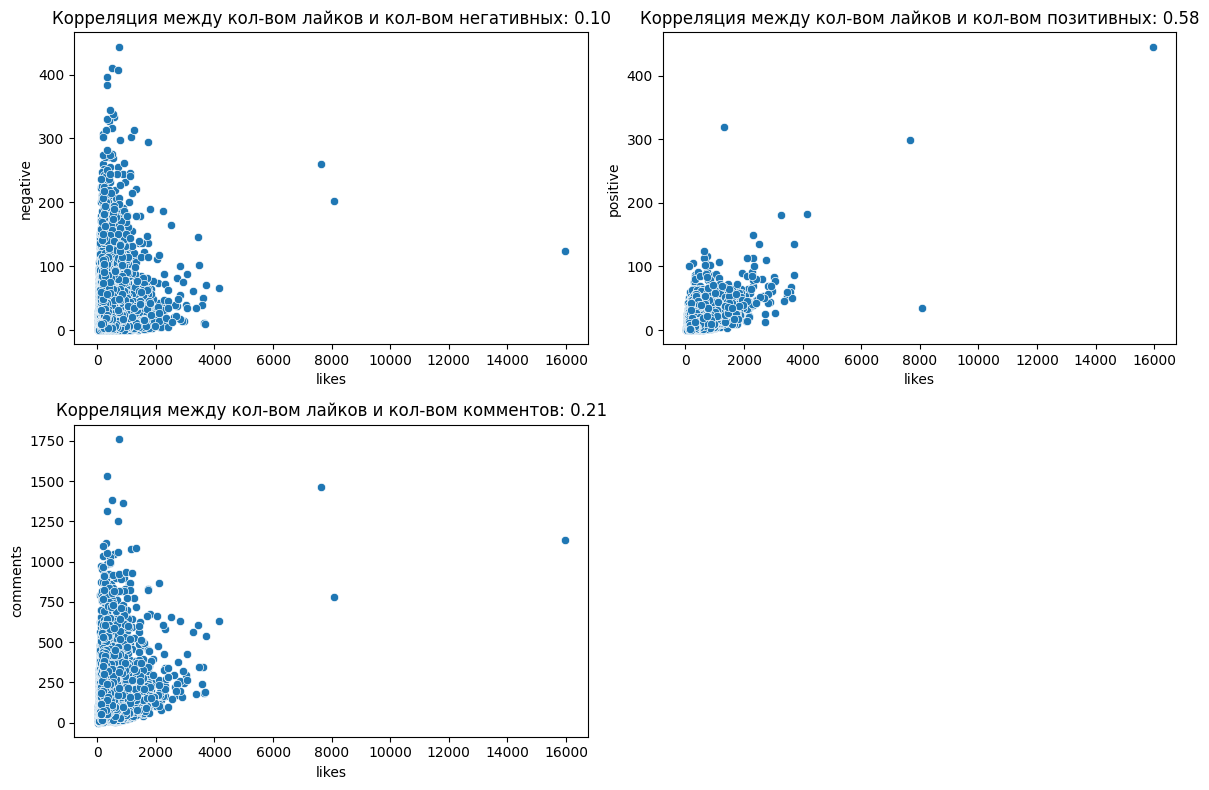

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


correlation_likes_negative = df_vk['likes'].corr(df_vk['negative'])
correlation_likes_positive = df_vk['likes'].corr(df_vk['positive'])

correlation_likes_total_comments = df_vk['likes'].corr(df_vk['comments'])

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.scatterplot(data=df_vk, x='likes', y='negative')
plt.title(f'Корреляция между кол-вом лайков и кол-вом негативных: {correlation_likes_negative:.2f}')

plt.subplot(2, 2, 2)
sns.scatterplot(data=df_vk, x='likes', y='positive')
plt.title(f'Корреляция между кол-вом лайков и кол-вом позитивных: {correlation_likes_positive:.2f}')

plt.subplot(2, 2, 3)
sns.scatterplot(data=df_vk, x='likes', y='comments')
plt.title(f'Корреляция между кол-вом лайков и кол-вом комментов: {correlation_likes_total_comments:.2f}')

plt.tight_layout()
plt.show()

Ни одну из посчитанных корреляций нельзя назвать большой, поэтому тяжело сказать что большое кол-во лайков на что-то влияет. Больше всего заметно что при большом кол-ве лайков будет много позитивных комментариев.

__[0.2]__  Давайте построим по сентимент-окрасу комментариев топ позитивных новостей.

- Если под новостью оставлено 100 комментариев, из которых 80 позитивные, мы можем быть уверены в том, что новость была хорошо воспринята людьми.
- Если под новостью всего один комментарий и он оказался позитивным, то у нас 100% позитивных комментариев, но это вовсе не означает, что новость была воспринята хорошо.

Получается, что сортировать по доле позитивных комментариев нельзя. Давайте поступим умнее. Доля позитивных комментариев под постом -- это случайная величина. Её довольно часто моделируют с помощью бета-распределения. Если это случайная величина, мы можем построить для неё предиктивный интервал. Пусть $u$ - число позитивных комментариев, а $d$ - нейтральных и негативных.  Пусть

$$
a = 1 + u \qquad b = 1 + d.
$$

Тогда нижняя граница $95\%$ предиктивного интервала для доли будет вычисляться по такой формуле:

$$
\frac{a}{a + b} - 1.65 \cdot \sqrt{\frac{a \cdot b}{(a + b)^2 \cdot (a + b + 1)}}
$$

Если под новостью был всего один комментарий, у такой случайной величины будет высокая дисперсия. Это означаen, что штука, которую мы вычитаем из доли, окажется высокой. Левая граница интервала окажется маленькой и мы не поднимем комментарий в нашем топе наверх. Фактически мы делаем сортировку по квантилю уровня $0.05$ вместо среднего.

От вас требуется вбить эту формулу, сделать сортировку и вывести на экран топ позитивных новостей. Подробнее про то, откуда берётся эта формула можно почитать [в этой книге.](https://disk.yandex.ru/i/Ctd08bTwC9eI3g) Ищите 4 главу, страницу 140.

In [68]:
def calculate_lower_bound(u, d):
    a = 1 + u
    b = 1 + d
    lower_bound = (a / (a + b)) - 1.65 * (a * b / ((a + b) ** 2 * (a + b + 1)))
    return lower_bound


df_vk['lower_bound'] = df_vk.apply(lambda row: calculate_lower_bound(row['positive'], row['negative']), axis=1)

sorted_df = df_vk.sort_values(by='lower_bound', ascending=False)
top_positive_news = sorted_df[['href', 'title', 'likes', 'comments', 'positive', 'negative', 'lower_bound']].head(10)

top_positive_news

,href,title,likes,comments,positive,negative,lower_bound
6651,https://rsport.ria.ru/rhythm_gym/20180913/1141...,Сборная России выиграла командный турнир на че...,1387,53,34.0,0.0,0.971018
17907,https://rsport.ria.ru/figure_skating/20171125/...,Российские фигуристы Боброва и Соловьев победи...,780,47,22.0,0.0,0.955698
1547,https://rsport.ria.ru/20190101/1548964679.html,Российские хоккеисты обыграли Канаду на молоде...,1235,94,42.0,1.0,0.954032
19150,https://rsport.ria.ru/chess/20171023/112766341...,Российская шахматистка Александра Костенюк ста...,924,57,21.0,0.0,0.953663
8122,https://rsport.ria.ru/aquatics/20180810/114028...,Кузнецов и Захаров победили в синхронных прыжк...,1163,38,19.0,0.0,0.948980
14187,https://rsport.ria.ru/fights/20180311/11339328...,Российские дзюдоисты победили в медальном заче...,844,38,18.0,0.0,0.946268
3726,https://rsport.ria.ru/figure_skating/20181117/...,Тарасова и Морозов победили в соревнованиях сп...,618,37,18.0,0.0,0.946268
8175,https://rsport.ria.ru/aquatics/20180809/114024...,Бондарь и Минибаев победили в синхронных прыжк...,931,41,17.0,0.0,0.943255
6511,https://rsport.ria.ru/rhythm_gym/20180916/1141...,Российские гимнастки взяли серебро ЧМ в упражн...,737,42,17.0,0.0,0.943255
5601,https://rsport.ria.ru/hockey/20181006/11433896...,Женская молодежная сборная России по хоккею вы...,832,32,17.0,0.0,0.943255


Построили? Срочно пришлите свою любимую позитивную  новость в общий чат!!!

Топ негативных новостей строить не будем. Вокруг итак слишком много негатива 😻😻😻

__[0.2]__ Какие категории новостей оказались самыми позитивными? Придумайте способ найти такие категории и опишите его тут.

__Ответ:__ см ниже

Давайте сначла посмотрим на точных данных а не наших предсказаниях, то есть на пересечении риа новостей и вк новостей, потому что там мы знаем теги благодаря данным риа

In [69]:
df_vk

,id,href,datetime,title,likes,comments,snippet,title_clean,snippet_clean,negative,neutral,positive,lower_bound
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN,в днр заявили о задержании диверсантов причаст...,#UNK#,10.0,35.0,2.0,0.195765
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN,житель урала заминировал тц изза снятия сотов...,#UNK#,11.0,28.0,3.0,0.231801
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN,в черном море нашли потерянный флот гитлера,#UNK#,4.0,15.0,3.0,0.403704
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN,в сша освободили задержанную российскую актрис...,#UNK#,10.0,28.0,2.0,0.195765
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN,толкнувший скабееву депутат рады заявил о гроз...,#UNK#,37.0,93.0,10.0,0.218745
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19923,17976905,/politics/20170929/1505812885.html,2017-09-29 03:51:03,"Политологи назвали губернаторов, которым грози...",141,114,NaN,политологи назвали губернаторов которым грозит...,#UNK#,31.0,77.0,4.0,0.130060
19924,17976766,/politics/20170929/1505809314.html,2017-09-29 03:20:41,"Захарова рассказала, какую книгу подписывал Ла...",140,50,NaN,захарова рассказала какую книгу подписывал лав...,#UNK#,11.0,29.0,8.0,0.410204
19925,17976601,/science/20170928/1505787196.html,2017-09-29 02:55:49,Современные люди появились более 300 тысяч лет...,202,69,NaN,современные люди появились более 300 тысяч лет...,#UNK#,11.0,56.0,0.0,0.068555
19926,17976198,/world/20170929/1505810992.html,2017-09-29 02:00:09,В США ребенок устроил стрельбу,138,51,NaN,в сша ребенок устроил стрельбу,#UNK#,10.0,40.0,1.0,0.138504


In [70]:
df_oob_2 = sorted_df[sorted_df.href.isin(test_hrefs)][['href', 'title', 'likes', 'comments', 'positive', 'negative', 'lower_bound']]

df_ria_oob = df_ria[df_ria.href.isin(test_hrefs)][['href', 'tags']]
df_oob_2 = df_oob_2.set_index('href').join(df_ria_oob.set_index('href')).reset_index()

df_oob_2

,href,title,likes,comments,positive,negative,lower_bound,tags
0,/20181206/1547493936.html,Эксперты определили самые бюджетные экзотическ...,127,57,5.0,5.0,0.468269,"путешествия - новости - sport stories,авиабиле..."
1,/20181206/1547516457.html,"Рада приняла закон, расширяющий контролируемую...",75,169,5.0,33.0,0.144869,"верховная рада украины,в мире"
2,/20181206/1547520788.html,Россия оказалась родиной древнейших титанозавр...,331,123,3.0,18.0,0.164036,"палеонтология,динозавры,ульяновская область,ри..."
3,/20181206/1547521406.html,"Школа в Красноярске ""превратилась"" в Хогвартс ...",248,130,11.0,19.0,0.363281,общество
4,/20181206/1547522342.html,Рада решила не продлевать договор о дружбе и с...,132,100,12.0,30.0,0.287822,"ситуация на украине,в мире"
...,...,...,...,...,...,...,...,...
1128,/20181231/1548959617.html,Число погибших при взрыве газа в Магнитогорске...,132,94,4.0,27.0,0.145276,"взрыв газа в жилом доме в магнитогорске,происш..."
1129,/20181231/1548960014.html,Как в России отреагировали на задержание амери...,140,83,12.0,17.0,0.406800,"мид рф,совет федерации рф,госдума рф,государст..."
1130,/20181231/1548960342.html,Медведев создал правкомиссию после ЧП в Магнит...,85,63,9.0,13.0,0.400625,"взрыв газа в жилом доме в магнитогорске,взрыв ..."
1131,/20181231/1548960674.html,В МЧС уточнили количество жертв при взрыве газ...,74,81,2.0,21.0,0.113298,"взрыв газа в жилом доме в магнитогорске,взрыв ..."


In [71]:
df_oob_2['tags'] = df_oob_2['tags'].str.split(',')

df_tags = df_oob_2.explode('tags')
tag_sentiment = df_tags.groupby('tags')['lower_bound'].mean()
sorted_tags = tag_sentiment.sort_values(ascending=False)
top_positive_tags = sorted_tags.head(10)

print(top_positive_tags)

tags
европейское космическое агентство    0.797727
марс-экспресс                        0.797727
самара                               0.749259
queen                                0.748212
галапагос                            0.715625
кубань                               0.715625
красная поляна                       0.715625
горячий ключ                         0.715625
внуково                              0.691837
осташков                             0.672194
Name: lower_bound, dtype: float64


Теперь попробуем довериться нашей модельке и ее предсказаниям и посмотреть позитивные теги на всей выборке новостей из вк

In [76]:
df_vk_with_categories = pd.read_csv('predicted_categories.csv')

df_vk_with_categories_merged = pd.merge(df_vk_with_categories, comments_grouped[['post_id', 'negative', 'neutral', 'positive']], left_on='id', right_on='post_id', how='left')
df_vk_with_categories = df_vk_with_categories_merged.drop('post_id', axis=1)
df_vk_with_categories

,id,href,datetime,title,likes,comments,snippet,title_clean,snippet_clean,target_tags,negative,neutral,positive
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN,в днр заявили о задержании диверсантов причаст...,#UNK#,['в мире'],10.0,35.0,2.0
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN,житель урала заминировал тц изза снятия сотов...,#UNK#,['происшествия'],11.0,28.0,3.0
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN,в черном море нашли потерянный флот гитлера,#UNK#,[],4.0,15.0,3.0
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN,в сша освободили задержанную российскую актрис...,#UNK#,"['сша', 'в мире', 'россия']",10.0,28.0,2.0
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN,толкнувший скабееву депутат рады заявил о гроз...,#UNK#,"['в мире', 'украина']",37.0,93.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19923,17976905,/politics/20170929/1505812885.html,2017-09-29 03:51:03,"Политологи назвали губернаторов, которым грози...",141,114,NaN,политологи назвали губернаторов которым грозит...,#UNK#,"['политика', 'россия']",31.0,77.0,4.0
19924,17976766,/politics/20170929/1505809314.html,2017-09-29 03:20:41,"Захарова рассказала, какую книгу подписывал Ла...",140,50,NaN,захарова рассказала какую книгу подписывал лав...,#UNK#,"['сергей лавров', 'россия']",11.0,29.0,8.0
19925,17976601,/science/20170928/1505787196.html,2017-09-29 02:55:49,Современные люди появились более 300 тысяч лет...,202,69,NaN,современные люди появились более 300 тысяч лет...,#UNK#,"['риа наука', 'открытия - риа наука']",11.0,56.0,0.0
19926,17976198,/world/20170929/1505810992.html,2017-09-29 02:00:09,В США ребенок устроил стрельбу,138,51,NaN,в сша ребенок устроил стрельбу,#UNK#,"['сша', 'в мире']",10.0,40.0,1.0


In [77]:
df_vk_with_categories['lower_bound'] = df_vk_with_categories.apply(lambda row: calculate_lower_bound(row['positive'], row['negative']), axis=1)
df_vk_with_categories

,id,href,datetime,title,likes,comments,snippet,title_clean,snippet_clean,target_tags,negative,neutral,positive,lower_bound
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN,в днр заявили о задержании диверсантов причаст...,#UNK#,['в мире'],10.0,35.0,2.0,0.195765
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN,житель урала заминировал тц изза снятия сотов...,#UNK#,['происшествия'],11.0,28.0,3.0,0.231801
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN,в черном море нашли потерянный флот гитлера,#UNK#,[],4.0,15.0,3.0,0.403704
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN,в сша освободили задержанную российскую актрис...,#UNK#,"['сша', 'в мире', 'россия']",10.0,28.0,2.0,0.195765
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN,толкнувший скабееву депутат рады заявил о гроз...,#UNK#,"['в мире', 'украина']",37.0,93.0,10.0,0.218745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19923,17976905,/politics/20170929/1505812885.html,2017-09-29 03:51:03,"Политологи назвали губернаторов, которым грози...",141,114,NaN,политологи назвали губернаторов которым грозит...,#UNK#,"['политика', 'россия']",31.0,77.0,4.0,0.130060
19924,17976766,/politics/20170929/1505809314.html,2017-09-29 03:20:41,"Захарова рассказала, какую книгу подписывал Ла...",140,50,NaN,захарова рассказала какую книгу подписывал лав...,#UNK#,"['сергей лавров', 'россия']",11.0,29.0,8.0,0.410204
19925,17976601,/science/20170928/1505787196.html,2017-09-29 02:55:49,Современные люди появились более 300 тысяч лет...,202,69,NaN,современные люди появились более 300 тысяч лет...,#UNK#,"['риа наука', 'открытия - риа наука']",11.0,56.0,0.0,0.068555
19926,17976198,/world/20170929/1505810992.html,2017-09-29 02:00:09,В США ребенок устроил стрельбу,138,51,NaN,в сша ребенок устроил стрельбу,#UNK#,"['сша', 'в мире']",10.0,40.0,1.0,0.138504


In [78]:
tag_sentiment = df_vk_with_categories.groupby('target_tags')['lower_bound'].mean()
sorted_tags = tag_sentiment.sort_values(ascending=False)

top_positive_tags = sorted_tags.head(10)
top_positive_tags

target_tags
['спорт', 'фигурное катание', 'велоспорт']                                                              0.946268
['другие виды спорта', 'биатлон']                                                                       0.927030
['легкая атлетика', 'теннис']                                                                           0.921276
['спорт', 'втб', 'теннис']                                                                              0.898299
['единоборства', 'фигурное катание', 'другие виды спорта']                                              0.897727
['легкая атлетика', 'тяжелая атлетика']                                                                 0.886500
['легкая атлетика', 'другие виды спорта']                                                               0.884486
['единоборства', 'художественная гимнастика', 'другие виды спорта', 'спортивная гимнастика']            0.882670
['спорт', 'фигурное катание', 'чемпионат мира по фигурному катанию 2018 года. милан'

топ-10 самых позитивных групп тегов

In [79]:
from ast import literal_eval

df_vk_with_categories['target_tags'] = df_vk_with_categories['target_tags'].apply(literal_eval)
df_tags = df_vk_with_categories.explode('target_tags')

tag_sentiment = df_tags.groupby('target_tags')['lower_bound'].mean()
sorted_tags = tag_sentiment.sort_values(ascending=False)

top_positive_tags = sorted_tags.head(10)
top_positive_tags

target_tags
хоккей с мячом                                          0.797727
художественная гимнастика                               0.793290
чемпионат мира по фигурному катанию 2018 года. милан    0.787104
19-25 марта                                             0.782797
стрелковый спорт                                        0.773484
спортивная гимнастика                                   0.735170
пхенчхан 2018                                           0.721154
паралимпийские игры - пхенчхан 2018                     0.721154
сборная россии - пхенчхан 2018                          0.721154
велоспорт                                               0.719817
Name: lower_bound, dtype: float64

топ-10 самых позитивных тегов

В целом самые позитивными оказались теги про спорт

__[0.2 бонусных]__ Проанализируйте, как температура комментария (вероятность того, что он негативный) зависит от длины трэда (число комментариев под новостью)? Значима ли эта взаимосвязь? Если вам для проверки этого хочется построить линейную регрессию, не сдерживайтесь.

In [80]:
merged_df = pd.merge(df_comments, df_vk[['id', 'comments']], left_on='post_id', right_on='id', how='left')

merged_df = merged_df.drop('id_y', axis=1)
merged_df = merged_df.rename(columns={'id_x': 'id'})

merged_df

,id,post_id,datetime,text,likes,sentiment_verdict,sentiment_score,comments
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0,neutral,0.912246,28
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0,neutral,0.879370,28
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0,positive,0.676261,28
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0,neutral,0.925939,28
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0,neutral,0.866223,28
...,...,...,...,...,...,...,...,...
2612624,17991829,17976037.0,2017-09-30 10:27:11,"Сергей, я про простых американцев, которые слу...",0.0,neutral,0.649754,241
2612625,17992004,17976037.0,2017-09-30 10:49:21,"[id415883695|Евгений], у них довольствие и они...",0.0,negative,0.697936,241
2612626,17992058,17976037.0,2017-09-30 10:56:29,"[id142882974|Сергей], ну Кадафи и Хусейныча он...",0.0,negative,0.623313,241
2612627,17992487,17976037.0,2017-09-30 11:56:03,"[id142882974|Сергей], для этого существует физ...",0.0,neutral,0.873600,241


In [81]:
negative_merged_df = merged_df[merged_df['sentiment_verdict'] == 'negative']
negative_merged_df

,id,post_id,datetime,text,likes,sentiment_verdict,sentiment_score,comments
14,24006399.0,24006362.0,2019-02-01 23:26:52,"[id109937745|Илья], привет жителям Окраины! Ка...",1.0,negative,0.791067,28
16,24006404.0,24006362.0,2019-02-01 23:28:27,"[id4710641|Евгений], а с чего это бюджетные де...",1.0,negative,0.579184,28
17,24006405.0,24006362.0,2019-02-01 23:28:38,"[id98684712|Андрей], ну да, только особо ничег...",1.0,negative,0.899649,28
26,24006419.0,24006362.0,2019-02-01 23:32:24,"[id281789680|Едыге], одного из раненых в очко",1.0,negative,0.482806,28
32,24006443.0,24006362.0,2019-02-01 23:40:05,Для путина и его шайки воров восстание русског...,0.0,negative,0.899264,28
...,...,...,...,...,...,...,...,...
2612620,17990119,17976037.0,2017-09-30 06:27:10,"[id142882974|Сергей], амеры как и Россия воююи...",0.0,negative,0.819313,241
2612623,17991797,17976037.0,2017-09-30 10:21:42,"[id415883695|Евгений], конечно за свои шкурные...",0.0,negative,0.547738,241
2612625,17992004,17976037.0,2017-09-30 10:49:21,"[id415883695|Евгений], у них довольствие и они...",0.0,negative,0.697936,241
2612626,17992058,17976037.0,2017-09-30 10:56:29,"[id142882974|Сергей], ну Кадафи и Хусейныча он...",0.0,negative,0.623313,241


Mean Squared Error: 0.017965768157843


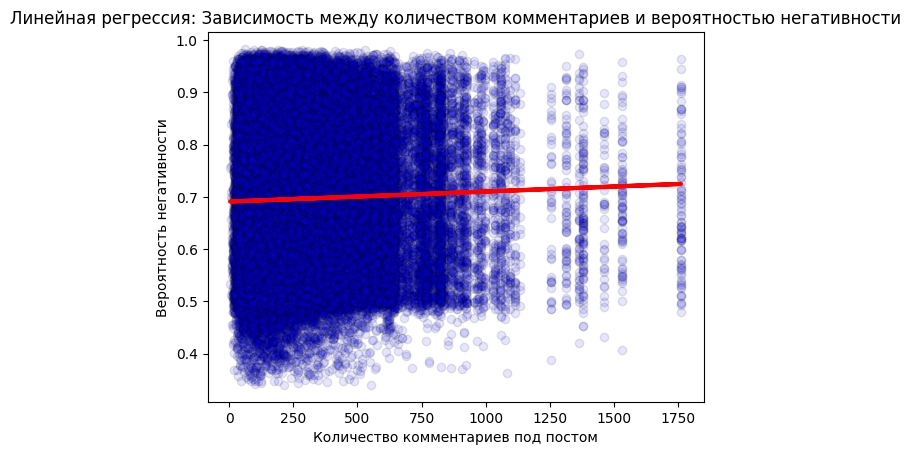

In [82]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = negative_merged_df[['comments']]
y = negative_merged_df['sentiment_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')

plt.scatter(X_test, y_test, color='blue', alpha=0.1, edgecolors='k')
plt.plot(X_test, y_pred, color='red', linewidth=3)
plt.xlabel('Количество комментариев под постом')
plt.ylabel('Вероятность негативности')
plt.title('Линейная регрессия: Зависимость между количеством комментариев и вероятностью негативности')
plt.show()

In [83]:
coef = model.coef_[0]
print(f'Коэффициент наклона: {coef}')

Коэффициент наклона: 1.9193425405194904e-05


Коэффициент наклона хоть и положительный, но крайне мал, что может говорить о том, что связь отсутсвует или крайне мала